## 신용 카드 이상 탐지 - 전통적 ML 비지도학습

- dataset는 2013 년 9 월 유럽 카드 소지자 신용 카드 거래로 만들었습니다. 이 dataset는 2 일 동안 발생한 거래를 보여 주며, 284,807 건의 거래 중 492 건의 fraud가 있습니다. 데이터세트는 매우 불균형하며 포지티브 클래스(사기)는 모든 거래의 0.172 %를 차지합니다.


- 이 dataset는 PCA 변환의 결과인 숫자 입력 변수만 포함합니다. 안타깝게도 기밀 유지 문제로 인해 데이터에 대한 원래 feature와 추가 background 정보를 제공할 수 없습니다. 특성 V1, V2, ... V28은 PCA로 얻은 principal component이며 PCA로 변환되지 않은 유일한 기능은 'Time' 과 'Amount' 입니다. '시간' 특성은 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 시간(초) 입니다. 'Amount' 특성은 거래금액 입니다.  'Class'는 사기의 경우 1, 그렇지 않으면 0 입니다.


- 클래스 불균형 비율이 주어지면 Area Under the Precision-Recall Curve (AUPRC)을 사용하여 정확도를 측정하는 것이 좋습니다. 불균형 data 분류에는 confusion matrix 정확도가 의미가 없습니다. 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from sklearn.metrics import classification_report, precision_score, recall_score, \
                        accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import time

In [2]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


## Exploratory Data Analysis

In [3]:
df.isnull().values.any()

False

In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
df.loc[:, "Time"] = df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) # 일중 시간

In [6]:
fraud = df[df['Class'] == 1].copy()
normal = df[df['Class'] == 0].copy()
fraud.shape, normal.shape

((492, 31), (284315, 31))

In [7]:
total = len(fraud) + len(normal)

print(f"Total = {total:,}")
print(f"Fraud = {len(fraud)/total*100:,.2f}%")
print(f"Normal = {len(normal)/total*100:,.2f}%")

outlier_fraction = len(fraud)/float(len(normal))
outlier_fraction

Total = 284,807
Fraud = 0.17%
Normal = 99.83%


0.0017304750013189597

### fraud / normal 거래의 금액 분포

In [8]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

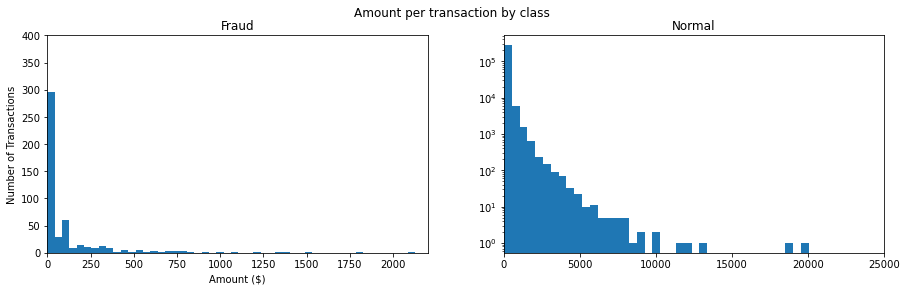

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
fig.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax1.set_xlabel('Amount ($)')
ax1.set_ylabel('Number of Transactions')
ax1.set_xlim(0, 2200)
ax1.set_ylim(0, 400)

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
ax2.set_xlim(0, 25000)
ax2.set_yscale('log')
plt.show();

- 금액을 log 분포로 변경

In [11]:
normal.loc[:,'Amount'] = np.log(normal.loc[:, 'Amount'] + 1)
fraud.loc[:, 'Amount'] = np.log(fraud.loc[:, 'Amount'] + 1)

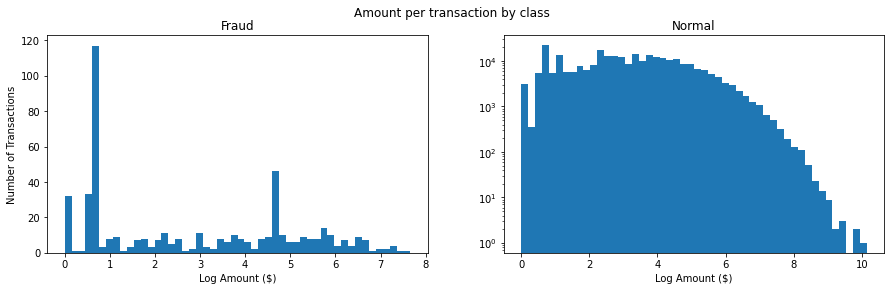

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
fig.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax1.set_xlabel('Log Amount ($)')
ax1.set_ylabel('Number of Transactions')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
ax2.set_xlabel('Log Amount ($)')
ax2.set_yscale('log')
plt.show();

## Visualize Preprocessed Transaction Features

훈련 세트에서 사기가 아닌 트랜잭션 1000 개를 샘플링하고 훈련 세트의 모든 사기 트랜잭션과 함께 플롯합니다. T-SNE 플롯은 이 특정 projection에서 Time 및 Amount 사전 처리 후 사기거래(빨간색)가 정상 거래(녹색)와 적절하게 분리된 것으로 보입니다.

In [13]:
tsne_df = pd.concat([normal.sample(1000), fraud]).reset_index(drop=True)

/Users/oyeongje/opt/anaconda3/envs/tf20/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


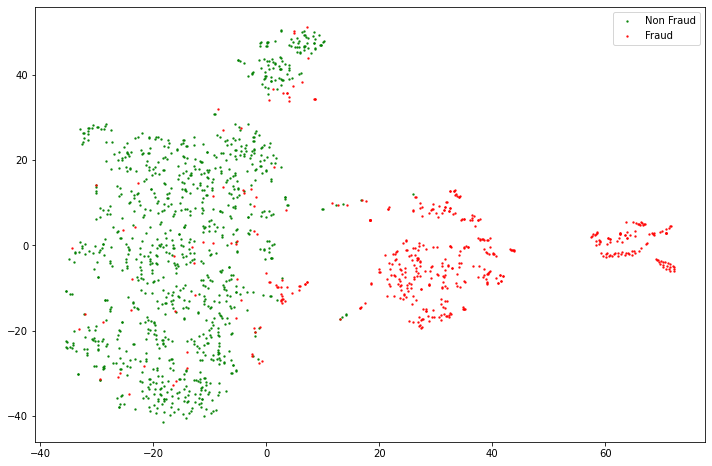

In [14]:
X = tsne_df.drop(['Class'], axis=1).values
Y = tsne_df['Class'].values

tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=0)
X_t = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_t[np.where(Y == 0), 0], X_t[np.where(Y == 0), 1], 
            marker='o', color='g', 
            linewidth=1, alpha=0.8, label='Non Fraud', s=2)
plt.scatter(X_t[np.where(Y == 1), 0], X_t[np.where(Y == 1), 1], 
            marker='o', color='r', 
            linewidth=1, alpha=0.8, label='Fraud', s=2)
plt.legend()
plt.show()

- feature / label 분리

In [15]:
y = df.pop('Class').values
X = df.values

X.shape, y.shape

((284807, 30), (284807,))

- Train / Test set 분리

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.1, random_state=0)
X_train.shape, y_train.shape

((256326, 30), (256326,))

In [17]:
sum(y_train == 1) / len(y_train)

0.0017048602170673284

## Model Prediction

### Local Outlier Factor(LOF) Algorithm

novelty : 기본값 = False (training data 에서만 outlier detect), unseen data 를 사용하여 predict() 를 하려면 True로 설정.

In [18]:
%%time

lof = LocalOutlierFactor(n_neighbors=20, 
                    contamination=outlier_fraction, 
                         novelty=True).fit(X_train)
lof

CPU times: user 9min 18s, sys: 2.26 s, total: 9min 20s
Wall time: 49.8 s


LocalOutlierFactor(contamination=0.0017304750013189597, novelty=True)

In [19]:
%%time
y_pred_lof = lof.predict(X_test)

CPU times: user 1min 6s, sys: 320 ms, total: 1min 6s
Wall time: 5.96 s


In [20]:
np.unique(y_pred_lof), sum(y_pred_lof == 1), sum(y_pred_lof == -1)

(array([-1,  1]), 28432, 49)

- metrics 출력

In [21]:
y_pred_lof[y_pred_lof == 1] = 0
y_pred_lof[y_pred_lof == -1] = 1

print(classification_report(y_test, y_pred_lof))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28426
           1       0.14      0.13      0.13        55

    accuracy                           1.00     28481
   macro avg       0.57      0.56      0.57     28481
weighted avg       1.00      1.00      1.00     28481



### Isolation Forest (격리 포리스트) Algorithm :

In [22]:
%%time
isof = IsolationForest(n_estimators=100, 
                contamination=outlier_fraction, 
                random_state=0, verbose=0).fit(X_train)

CPU times: user 16.5 s, sys: 1.8 s, total: 18.3 s
Wall time: 18.3 s


In [23]:
%%time
y_pred_isof = isof.predict(X_test)

np.unique(y_pred_isof), sum(y_pred_isof == 1), sum(y_pred_isof == -1)

CPU times: user 848 ms, sys: 15.9 ms, total: 863 ms
Wall time: 865 ms


(array([-1,  1]), 28425, 56)

In [24]:
y_pred_isof[y_pred_isof == 1] = 0
y_pred_isof[y_pred_isof == -1] = 1

print(classification_report(y_test, y_pred_lof))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28426
           1       0.14      0.13      0.13        55

    accuracy                           1.00     28481
   macro avg       0.57      0.56      0.57     28481
weighted avg       1.00      1.00      1.00     28481



## Compare models

In [25]:
predictions = {"lof": y_pred_lof, "isof": y_pred_isof}

lof: 90
Accuracy Score : 0.99684
Precision Score: 0.14286
Recall Score   : 0.12727



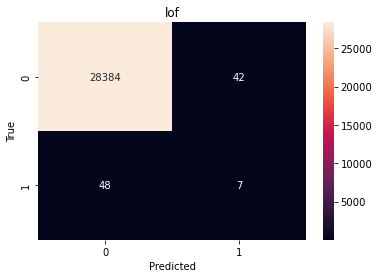

isof: 73
Accuracy Score : 0.99744
Precision Score: 0.33929
Recall Score   : 0.34545



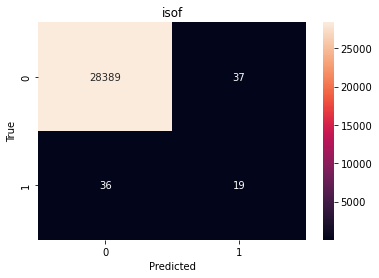

In [26]:
for clf_name, y_pred in predictions.items():
    
    n_errors = (y_pred != y_test).sum()
    
    # Run Classification Metrics
    print(f"{clf_name}: {n_errors}")
    print(f"Accuracy Score : {accuracy_score(y_test, y_pred):.5f}")
    print(f"Precision Score: {precision_score(y_test, y_pred):.5f}")
    print(f"Recall Score   : {recall_score(y_test, y_pred):.5f}")
    print()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    ax = sns.heatmap(cm, annot=True, fmt='d')
    ax.set_title(clf_name)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    plt.show()